In [5]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math
import os

# Specify the directory path
directory_path = './data/downloaded/ericcahan/'

# Get all file names in the directory
file_names = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
print(len(file_names))

62


In [6]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    pixel_values = np.array(image).reshape(-1, n_dims)
    
    # Convert normalized values to 0-255 range if necessary
    if pixel_values.max() <= 1.0:
        pixel_values *= 255
    
    r, g, b = pixel_values.T
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

In [22]:
import math

def extract_color_pca_radial(image_name: str):
    file_name = directory_path + image_name
    rgb_values = get_df_rgb(file_name)

    rgb_array = rgb_values.values

    # Initialize the PCA model with 2 components
    pca = PCA(n_components=2)

    # Fit the PCA model to your data
    pca.fit(rgb_array)

    # Transform the RGB values to the first two principal components
    pca_components = pca.transform(rgb_array)

    center = np.mean(pca_components, axis=0)

    # Calculate angles (starting from x axis)
    angles = np.arctan2(pca_components[:,1] - center[1], pca_components[:,0] - center[0])
    angles = np.mod(angles, 2 * np.pi)
    # sort angles
    sorted_indices = np.argsort(angles)

    # reorder angles
    angles = angles[sorted_indices]

    # Calculate distances
    distances = np.sqrt((pca_components[:,0] - center[0])**2 + (pca_components[:,1] - center[1])**2)
    max_distance = np.max(distances)

    # Create lines
    num_segments = 10
    segment_angles = np.linspace(0, 2 * np.pi, num_segments, endpoint=False)
    segment_degrees = np.rad2deg(segment_angles)
    segment_lines = [(center[0], center[1], max_distance * np.cos(a), max_distance *  np.sin(a)) for a in segment_angles]

    # Determin points inside segments
    points_inside_segments = []
    for a1, a2 in zip(segment_angles, np.roll(segment_angles, -1)):
        if a2 > a1:
            points_inside = sorted_indices[(angles >= a1) & (angles < a2)]
        else:
            points_inside = sorted_indices[(angles >= a1) | (angles < a2)]
            if a1 > 2 * np.pi - (a2 - a1):
                points_inside = sorted_indices[(angles >= a1) & (angles < a2) | (angles < a2 - 2 * np.pi)]
        points_inside_segments.append(points_inside)


    segment_colors = []

    # Plot
    # plt.scatter(pca_components_x, pca_components_y, c='black', label="Original data")
    for i, line in enumerate(segment_lines):
        plt.plot([line[0], line[0] + line[2]], [line[1], line[1] + line[3]], color='black')

        # Scatter plot with points inside segments colored based on the segment
        # segment_color = segment_colors(i)
        segment_distances = distances[points_inside_segments[i]]
        colors_inside_segment = rgb_array[points_inside_segments[i]]
        # biggest_distance_idx = np.argmax(segment_distances)
        # segment_color = colors_inside_segment[biggest_distance_idx]
        segment_color = np.mean(colors_inside_segment, axis=0)
        # closet_index = np.argmin(np.linalg.norm(colors_inside_segment - segm, axis=1))
        # farthest_color = np.argmax(colors_inside_segment - center_color, axis=0)
        # print(farthest_color)
        # print(segment_color)
        # segment_color = segment_colors(i)
        if math.isnan(segment_color[0]) or math.isnan(segment_color[1]) or math.isnan(segment_color[2]):
            continue
        segment_colors.append({
            "r": segment_color[0],
            "g": segment_color[1],
            "b": segment_color[2]
        })
    return segment_colors
        

[196.67978017 154.4000348  143.88774427]
[187.82663955 138.02123429 128.10753323]
[170.82218237 129.46457968 124.32611052]
[157.58091605 123.74956123 124.87552408]
[136.17758529 116.31377888 122.02282623]
[118.66774569 119.46366076 125.38252675]
[132.91631272 142.3970337  143.33323569]
[141.20834497 153.98054237 150.95918261]
[158.22846192 173.58419584 165.80377676]
[183.86854476 174.4059999  160.72381257]
[228.53206523 176.01314444 126.66780945]
[239.87928618 132.56890591  50.25581613]
hi
hi
[ 0.17633491 10.19590948 30.32325569]
[ 0.74142659 41.65502475 83.13555429]
[  8.85309244  74.52365784 123.58001526]
[ 31.30734453 102.68891007 148.23844244]
[ 69.61410178 132.65010155 166.50520804]
[151.00382506 170.53888171 168.39596992]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 17.73647133  61.9035696  122.76836554]
[110.97968397 190.48984199 184.13995485]
[122.7544484  196.04982206 186.27758007]
[163.42631449 211.15465317 187.6899531 ]
[211.94484055 231.68933004 223.78587073]
[175.71990493 209.76883716 247.39131802]
[133.47430586 187.34441439 248.3388168 ]
[112.74599851 174.25879125 241.84983272]
[ 92.16960907 158.61582197 229.51891285]
[ 52.83788343 119.29014487 194.65486635]
[229.6947833  179.91875016  96.58290058]
[205.08024114 133.19275543  56.05233344]
[150.98950131 104.16141732  41.50393701]
hi
[15.61602987 55.3212809  73.20459013]
[ 39.47846341 101.74642753  99.19873524]
[ 81.30024606 134.82970039 111.44400058]
[ 92.26792926 144.55193507 115.73834451]
[108.31288548 159.84766611 122.96358985]
[169.42223218 196.53300162 132.87582285]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[224.03527383  91.34656758 124.25319259]
[239.8921339  109.42808927 128.74491436]
[248.23510208 119.92309545 127.78547537]
[252.93175256 129.19428468 122.33423511]
[252.89797243 152.58048721 115.48706902]
[253.79323572 161.17711061  95.33973453]
[242.70249901 125.201309   101.97183657]
[239.0009265  119.87430513 102.96602841]
[236.823143   115.31960586 104.96563921]
[204.28608646  72.79885658 116.19751456]
[197.66290247 179.95720202 125.64207257]
[139.57785043 132.91622395 102.87413159]
[107.40100671 111.75       120.78020134]
[103.33379791 109.20209059 119.93728223]
[ 43.97272509  66.7276675  103.98023777]
[ 66.5832017   90.67052176 123.46676666]
[ 93.33445114 109.77662195 135.22912675]
[101.7828468  114.66920118 137.70450328]
[110.91402834 121.85311352 140.37298846]
[151.78062186 151.99834875 148.46996169]
[30.82122249 53.47716381 64.61672372]
[  0.17827877  90.90222649 104.69296878]
[  2.19871701 111.7716438  127.03858286]
[ 25.23867498 126.2823921  141.43067647]
[ 54.16889696 140.9

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 50.03882382 101.47228358 154.90824407]
[ 31.30019903  72.23844185 107.01939153]
[142.58333333 153.66666667 155.5       ]
[247.03445296 100.58483628  66.12586178]
[245.78467642 157.58398033 104.71563593]
[219.70160835 193.54281415 160.02892212]
[191.95534432 198.82930597 204.02690791]
[147.69121863 189.3492219  217.71407886]
[109.93904154 170.11872458 214.13509165]
[ 79.83316707 142.58496033 197.21588523]
[200.26860215 171.87470175 139.64620117]
[161.20474407 147.3196005  114.02496879]
[121.68811881 128.03465347 139.86633663]
[119.51459854 127.47445255 139.6459854 ]
[ 70.55364717  93.48807047 132.24288112]
[ 94.290387   113.82117723 146.22174504]
[111.66514599 127.73911627 152.78841893]
[118.20418178 131.99355665 154.4965223 ]
[126.2026855  137.98877185 155.3621947 ]
[159.85177399 158.08681801 156.80078321]
[215.66461307 182.52005828 123.66931698]
[200.10220325 168.17894951 116.30148082]
[199.3134681  187.45655028 148.15095826]
[176.53664428 178.54620996 159.47309049]
[183.47866998 18

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[210.77590275 184.01515417 141.84951748]
hi
hi
hi
[  0.15798412 121.28319921 122.93963917]
[ 33.32022613 156.65720964 146.5774018 ]
[ 93.66419198 176.8516846  158.76706466]
[107.2871651  180.44699681 159.56156301]
[118.53898807 183.20965352 159.3465881 ]
[203.5995459  203.8581922  176.04008465]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[105.74558897 117.47471421 158.51267396]
[170.08050152 158.22381064 161.71830326]
[209.67418398 188.77566766 169.8251632 ]
[226.48903481 209.68991457 191.81076544]
[233.22862837 230.35736797 222.66414849]
[216.16821421 223.3190674  241.86983571]
[190.61863551 199.31282754 236.0186307 ]
[183.81948025 193.40633847 234.16737798]
[177.70413041 188.22454173 232.45768133]
[136.99118739 149.86666716 218.01014875]
[169.1719786  167.32310674 167.58013687]
[134.96735237 131.2966943  130.21481936]
[126.95103816 123.95917508 123.72825477]
[118.29544139 115.13531114 115.40340087]
[62.15172516 72.04990153 86.08583545]
[ 62.52458435  85.4669028  109.24611326]
[102.35849684 121.29181909 138.99975058]
[110.79464462 126.82122465 142.4048041 ]
[115.86848033 130.88268931 145.48241206]
[185.19280542 186.95981654 189.11406564]
[160.93547035 179.95566407 162.43552676]
[159.68069735 191.62604052 178.4286163 ]
[158.50667476 194.32220874 183.4538835 ]
[158.18799082 197.08698804 188.08143047]
[153.28051824 205.8

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[101.16735244  79.03161353 207.24706639]
[130.32722735 111.37629497 242.48135242]
[127.02014652 131.72137073 250.65230384]
[139.25655134 153.82332102 253.88992739]
[174.98072138 179.45333068 254.6466169 ]
[219.00811678 195.53062074 254.6506432 ]
hi
hi
hi
[ 57.20911427  35.46945566 148.82967612]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[38.91392198 87.70220774 99.37988648]
[120.9738041  100.22892938  56.43735763]
[149.64311099 118.94368507  63.34376709]
[188.86137663 144.14958205  77.42658881]
[224.08403821 176.69168087 114.11092177]
[185.2620059  177.05929859 149.75896427]
[135.66865165 154.9346714  145.40809872]
[119.77906302 146.02934453 141.08608865]
[108.26492596 138.85798598 137.10723507]
[ 79.42728734 120.42295037 124.34049321]
[ 0.38662781 40.71278492 81.28857619]
hi
hi
[253.         178.85714286 138.42857143]
[241.31194634 219.07234256 204.511399  ]
[172.82107439 192.54584637 199.19192857]
[114.81974727 156.15712752 177.34448299]
[103.76127014 149.27299925 172.71782145]
[ 90.25328641 141.34603043 167.72111238]
[ 29.78193738  97.36004179 136.14185225]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[135.4761734   87.43524015 113.28820798]
[172.43355575  93.29098966 103.52717364]
[178.57265749  95.47280307 103.1891874 ]
[189.52120791 100.48399861 102.5556404 ]
[228.2315055  112.42591439  84.97388323]
[245.6322512   95.35744545  49.06531134]
[227.38395899  48.92785048  22.48950871]
[174.90033223  60.18139535  49.14817276]
[173.140625  89.59375   92.34375 ]
[ 91.80420258  76.70256617 112.96057888]
[247.787788   235.56743643 211.21245062]
hi
hi
hi
[ 59.19695499 171.23991853 237.30771201]
[ 91.59701129 193.7687286  251.82465568]
[138.35553919 206.09687087 253.03800499]
[148.91295265 208.66094089 252.83673785]
[160.44226003 211.27346357 252.50805078]
[209.82218892 225.94954876 245.12808595]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[  0.53521632 115.44937289 184.55791554]
[76.2027802  39.95486847 53.15902007]
[190.72094684  68.92062034  75.10396898]
[242.95980457 163.0850167  110.90998796]
[240.48133922 224.77207739 186.78822467]
[206.87050352 246.58622427 246.75250606]
[152.85635801 237.01028064 252.93178697]
[116.04697852 219.68216724 245.86250251]
[ 81.327339   205.76643985 239.16534629]
[  7.94389493 169.04339313 218.56294585]
[131.23337466 210.50294291 226.80222915]
[ 69.89470031 188.19341964 218.06229827]
[ 27.39092107 175.71223022 213.24345594]
[  0.3914471  146.44059527 195.39967065]
[  0.18955699 101.78530184 161.23512288]
[ 0.25598972 46.64975962 98.35344991]
hi
hi
hi
[206.43377843 225.54284973 236.38402911]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[165.3566705  163.76236343 200.34020647]
[187.03497942 160.22736626 141.97839506]
[210.5584999  173.72369246 144.82763424]
[241.47183906 199.12288411 156.25140423]
[245.69039554 213.39969574 172.69040568]
[232.85393283 222.55930919 194.62675842]
[218.56857358 217.81336232 205.92228208]
[208.29953603 208.08112302 210.44274833]
[199.35120372 198.50791574 210.61610297]
[184.4206971  183.88975943 207.90838455]
[143.66372725 167.76700415 197.38270244]
[203.57548718 188.60666667 204.61138462]
[216.81896449 193.39686715 203.96101877]
[234.84050878 207.54207124 196.59273993]
[248.45892798 236.83286292 208.34335785]
[228.05187847 232.1932548  227.75202291]
[206.86057108 220.36362562 227.64575739]
[197.46355886 213.49829483 224.50748075]
[191.49965906 208.50196337 221.61692022]
[171.42451314 193.04566575 212.68018557]
[207.93000819 125.4184912   86.21202402]
[180.99103652 101.14370173  75.75846286]
[158.97368421  86.          70.15789474]
[143.14285714 122.71428571 105.71428571]
[ 84.96507327 10

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[121.10165454 127.00542425  93.73494339]
[136.48975412 153.67702421 125.50041085]
[154.29286668 171.45944516 142.01756243]
[166.93360878 181.94349903 151.0310652 ]
[198.14464996 205.46793556 172.49150145]
[230.07180044 219.81587685 170.63721953]
[211.77742817 188.54624493 121.04144241]
[203.17926195 174.9553158  101.02797537]
[190.22268435 158.2958071   82.06078575]
[144.69589543 112.31140549  44.5351916 ]
[ 83.11028954 180.21156641 189.88739359]
hi
hi
[218.22732491 166.07233065 131.15767317]
[222.59125186 193.45946398 152.00327863]
[201.84272693 216.29560962 186.44891102]
[176.73917722 220.68925384 205.05146741]
[156.23478225 218.00759853 210.62734093]
[139.46742496 212.03712788 209.64054021]
[118.10089509 201.01950254 203.64084689]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[178.57394605  86.71529755  48.21621255]
[215.3099463  102.89168054  47.98618134]
[232.35882409 110.42347995  49.92617129]
[245.83634982 124.51972921  57.12332136]
[250.42725119 141.25827671  71.75553916]
[252.06991297 164.37559725  91.96647475]
[219.02227102 143.42785445  79.28105395]
[210.42930591 130.48971722  70.86118252]
[207.56348074 127.55206847  68.87446505]
[81.06753694 43.69399608 26.69985297]
[190.84329438 161.76374051 152.4200988 ]
[161.34228188 153.77577009 154.48970344]
[152.59671026 151.01070471 153.86247656]
[145.86439271 147.27700486 152.99638354]
[123.92818656 138.86916559 147.85682373]
[113.17366276 130.51110551 137.96663305]
[149.5257732  142.18806926 137.6276649 ]
[161.78800897 137.67781098 121.52661561]
[178.03968536 145.07720445 121.97981107]
[195.60857978 156.40093793 135.19933549]
[95.47766128 92.9354054  83.26405731]
[152.76962298 136.32381563 112.04883165]
[173.30922653 150.78263337 121.12262851]
[180.43176744 164.22706975 142.7038939 ]
[202.77992455 194.8345

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 73.95281574 126.45729928 151.46528067]
[117.46497765 123.13442623 110.8247392 ]
[147.33436214 163.14609053 131.12242798]
[211.30152229 183.80809205 105.72755037]
[199.07412853 207.40316257 148.69081154]
[178.35303165 216.49306615 183.36514954]
[145.46541996 201.72129223 186.39575302]
[127.56467898 188.65357244 180.21565655]
[117.00995177 179.51211787 175.67095799]
[ 99.03991649 160.23118202 167.3513571 ]
[ 0.77446358 29.23785639 70.69433212]
hi
hi
[235.55291751 188.65452716 110.37183099]
[233.35394568 211.0918639  174.58251394]
[192.76753273 196.91621908 196.24849393]
[129.76089853 156.0206739  177.0432134 ]
[117.49096648 147.71865477 172.25604049]
[102.87032381 138.5648078  167.19147003]
[ 43.48324052  93.51745442 137.12772263]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[241.41846908 163.64955454 125.71754447]
[181.14737976 102.24343168 106.49553609]
[125.74850444  79.51438153 103.67626443]
[ 90.35784962  66.41151794 100.36049428]
[  0.37819281  68.76764375 127.37048275]
[ 15.47113152  99.50716451 150.27070838]
[ 69.47397248 129.23887987 171.1300094 ]
[ 91.3529313  141.54915769 179.23519089]
[127.41947336 162.57780886 191.15302008]
[192.54553758 187.52944938 189.77547202]
[240.82311041 199.77507646 171.92115302]
[212.01369082 158.83590036 136.05495341]
hi
[19.64444444 86.04444444 83.2       ]
[  0.39934918 129.97281134 145.39516534]
[ 31.08322211 174.19406467 190.02095283]
[ 83.05216294 195.77576248 205.68153443]
[105.87524656 205.51557465 209.49122156]
[128.98720907 212.20597045 208.10052621]
[190.55211446 217.1768881  198.49584284]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[231.88895698 192.09564544 169.78764278]
[190.41724323 160.98318895 152.48773864]
[156.90274314 143.02743142 141.52369077]
hi
[159.11015946 217.45903382 234.23202963]
[183.39353391 223.76240819 234.13665448]
[200.19876826 225.51366254 230.74961647]
[212.18454834 226.44931649 224.8969439 ]
[224.69784415 224.82433488 214.0669357 ]
[236.94685525 214.51926768 190.47454039]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[113.54647261  96.87101273  99.82896705]
[194.37281962 135.8791352  127.81865268]
[241.58208726 167.50609716 144.75407754]
[252.71647676 204.34933937 169.30735935]
[243.88137183 229.7553276  207.72645798]
[221.81588123 230.35703653 223.80965576]
[193.82053708 217.88568881 222.34212394]
[178.90863575 211.58104004 220.48522014]
[157.39484274 199.91924714 216.81347079]
[123.6312429  179.78151846 205.53483314]
[ 93.54682578  25.01788218 170.58548963]
hi
hi
[227.53091586 136.81227437 153.97461427]
[239.25797974 159.96629797 185.96626749]
[223.99569331 162.68289541 206.50677232]
[177.80476816 115.79472993 197.72931343]
[173.92308659 111.7115967  197.41554101]
[169.65819363 107.58988028 196.18699321]
[135.05845742  70.49750066 189.33849059]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[227.38211163 177.49555436 141.91022405]
[225.71889504 120.79121888  95.38961555]
[155.29275894  86.17011916  84.88542621]
[107.9047619   67.76190476  70.85714286]
[ 22.01655542 118.38277185 127.98631357]
[ 54.73191602 142.61621369 150.78364007]
[ 84.5723417  159.11004794 165.60838259]
[ 97.5262025  165.98798594 171.88161652]
[118.51127561 175.19641793 177.76495394]
[176.02265591 193.298281   186.38954063]
[ 33.59103835 139.06395372 197.97547306]
[138.61309524 185.2797619  204.4702381 ]
[150.25966851 191.06629834 208.02209945]
[161.6557377  197.63934426 211.27868852]
[224.0626043  229.76463348 241.54270889]
[192.79189714 227.04655483 240.38923055]
[146.07020346 205.94144106 236.5080713 ]
[139.45988425 203.46864546 236.57032868]
[130.25086077 199.85065634 235.25669787]
[ 74.8988173  172.15821257 221.4098278 ]
[ 29.19852182  41.51241248 100.90215715]
hi
[202. 121. 100.]
[248.6838024  152.90857329 107.68990293]
[249.33786542 184.47957255 174.53611179]
[221.48609023 173.55405065 213.373870

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 79.50890315  28.35454081 129.16357958]
hi
hi
[ 63.00482109 143.83628938 142.95519483]
[ 83.98705709 130.23245086 163.52226233]
[112.8520424  121.97861308 174.31755801]
[131.29110555 106.59489369 179.93485218]
[133.52907332  84.99198584 177.78023607]
[123.39158497  65.68199604 169.15894422]
[108.53935736  50.28999638 156.34691587]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[157.84228122  45.66768722  62.08796494]
[193.60291016  68.97226563 102.80308594]
[211.93344617  86.96040621 109.60097927]
[224.06459435 104.50594055 114.33325251]
[246.20138275 168.14459911 139.57588695]
[248.51620748 153.34240606  85.03305683]
[245.28195864 132.43950342  55.91015195]
[234.44305239 107.40998827  48.89542348]
[218.91094694  89.88092148  53.79166875]
[189.32787038  66.61621102  48.61970593]
[ 29.24304949  41.50854494 100.92761899]
hi
[202. 121. 100.]
[248.6609655  152.8792334  107.66456743]
[249.31429582 184.49734826 174.58312316]
[221.44481674 173.56603626 213.40291888]
[157.89742074 133.16652054 208.63305128]
[133.6342675  119.63886177 201.67590306]
[111.61777438 105.49976846 190.32442064]
[ 70.96903173  76.70594242 157.12066535]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[130.47589713 135.41576019 152.63734628]
[117.35915368 154.15406901 172.71236961]
[131.00314953 160.92622357 176.84606059]
[152.34931409 153.67611491 166.82472157]
[178.64998017 161.78493872 162.89261099]
[196.92522569 162.0988268  149.00500506]
[176.79391739 143.03565192 133.8851761 ]
[156.92305164 134.73981221 132.79342723]
[142.70945768 129.90494799 133.89729102]
[ 99.55051136 110.73465612 125.60079828]
[  0.25136109 107.30084525 162.00026725]
[56.63771384 44.78872473 31.0125972 ]
[130.92262613  97.69237303  73.02216749]
[199.24982065 153.88231266 121.09032805]
[217.29284749 204.80472897 169.78795686]
[174.81231421 216.10350567 217.40777944]
[120.51717565 201.75390418 232.2681117 ]
[ 86.63953398 188.62996805 231.22340633]
[ 55.65838965 174.2920731  225.7196479 ]
[  6.18768871 145.39096829 202.92768092]
{"Sag Harbor, NY - Sunset 7:55pm.jpg": [{"r": 196.6797801683536, "g": 154.40003479867764, "b": 143.8877442657179}, {"r": 187.8266395526182, "g": 138.02123429442952, "b": 128.107533226

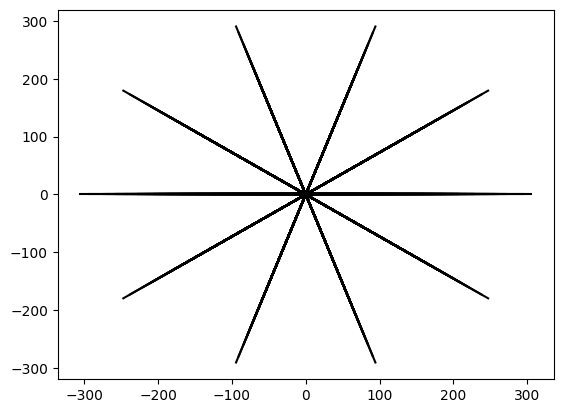

In [24]:
color_data = {}

for file_name in file_names:
    color_data[file_name] = extract_color_pca_radial(file_name)

# color_data[file_names[10]] = extract_color_pca_radial(file_names[10])
import json

# Convert the dictionary to a JSON string
json_data = json.dumps(color_data)

# Print the JSON string

# Save the JSON string to a file
with open("data.json", "w") as json_file:
    json.dump(color_data, json_file)